In [57]:
import math
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [5]:
breast_cancer = load_breast_cancer()
print(breast_cancer['DESCR'])

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

# Process Data

In [15]:
df_bc = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
df_bc['target'] = breast_cancer['target'] # target cancer type - malignant/benign (1/0)

print(f'Dataset size: {df_bc.shape}')
df_bc.head()

Dataset size: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
df_bc['target'].value_counts() / len(df_bc) * 100

1    62.741652
0    37.258348
Name: target, dtype: float64

This means roughly 62.7% cases are malignant and 37.3% are benign.

In [17]:
# Split dataframe into train and test
df_train, df_test = train_test_split(df_bc, test_size=0.2, random_state=42, stratify=df_bc['target'])
df_train = df_train.reset_index()
df_test = df_test.reset_index()
print(f'Size of train set: {df_train.shape}')
print(f'Size of test set: {df_test.shape}')

Size of train set: (455, 32)
Size of test set: (114, 32)


In [18]:
# Check distribution of class labels in train set
df_train['target'].value_counts() / len(df_train) * 100

1    62.637363
0    37.362637
Name: target, dtype: float64

In [19]:
# Check distribution of class labels in test set
df_test['target'].value_counts() / len(df_test) * 100

1    63.157895
0    36.842105
Name: target, dtype: float64

In [22]:
# Distribution of train
df_train.describe()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,276.654945,14.067213,19.247363,91.557407,648.541099,0.096167,0.103869,0.089193,0.048344,0.180618,...,25.647297,106.625297,869.026593,0.132329,0.254329,0.276578,0.113904,0.290865,0.083945,0.626374
std,164.998497,3.499380,4.405291,24.149231,344.944564,0.013458,0.053522,0.081747,0.038925,0.028074,...,6.225470,33.195053,552.926912,0.022550,0.159882,0.215937,0.066784,0.064624,0.018408,0.484299
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,132.500000,11.635000,16.000000,74.720000,415.650000,0.086475,0.063750,0.028010,0.020220,0.161750,...,21.090000,83.715000,513.900000,0.115950,0.145850,0.107900,0.063390,0.249400,0.071835,0.000000
50%,276.000000,13.270000,18.820000,85.980000,541.800000,0.095660,0.090970,0.059990,0.032630,0.178100,...,25.400000,97.590000,683.400000,0.131400,0.211600,0.229800,0.097220,0.281900,0.079930,1.000000
75%,418.500000,15.740000,21.710000,103.700000,770.050000,0.104850,0.130100,0.132200,0.073820,0.195300,...,29.370000,124.950000,1033.500000,0.146200,0.336800,0.385300,0.162500,0.320100,0.092070,1.000000
max,566.000000,28.110000,39.280000,188.500000,2499.000000,0.144700,0.345400,0.426800,0.201200,0.304000,...,49.540000,229.300000,3432.000000,0.218400,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [23]:
# Distribution of train
df_test.describe()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,313.315789,14.367079,19.458421,93.611930,680.225439,0.097130,0.106225,0.087227,0.051215,0.183332,...,25.796667,109.799298,926.707895,0.132527,0.254011,0.254668,0.117408,0.286924,0.083951,0.631579
std,159.345304,3.626623,3.870388,24.928082,379.002396,0.016305,0.050065,0.071367,0.038397,0.024598,...,5.844268,35.218674,631.217286,0.024028,0.147410,0.176207,0.061556,0.049475,0.016683,0.484506
min,1.000000,7.760000,11.970000,47.920000,181.000000,0.052630,0.031160,0.000000,0.000000,0.135300,...,14.100000,59.160000,268.600000,0.088640,0.052320,0.000000,0.000000,0.199900,0.059330,0.000000
25%,200.750000,11.890000,16.685000,76.375000,434.250000,0.085377,0.067132,0.039090,0.022295,0.164250,...,21.022500,85.075000,515.950000,0.120025,0.148600,0.121400,0.073853,0.253150,0.071180,0.000000
50%,307.500000,13.680000,19.025000,87.910000,571.450000,0.096870,0.097620,0.066940,0.041650,0.184350,...,25.430000,98.790000,693.300000,0.131200,0.217700,0.210650,0.109550,0.282250,0.080535,1.000000
75%,450.250000,16.245000,21.922500,106.525000,811.050000,0.107500,0.131525,0.117375,0.073072,0.197375,...,30.377500,128.425000,1145.000000,0.145450,0.342350,0.375800,0.157000,0.307475,0.092165,1.000000
max,568.000000,27.420000,29.330000,186.900000,2501.000000,0.163400,0.277000,0.363500,0.187800,0.259500,...,41.850000,251.200000,4254.000000,0.222600,0.868100,0.938700,0.268800,0.475300,0.143100,1.000000


# Baseline Models

1. Random classifier
2. Majority class classifier

In [33]:
def random_classifier(row):
    return 1 if random.random() > 0.5 else 0

In [34]:
majority_class = df_train['target'].value_counts().index[0]

In [35]:
# Augment test dataframe with baseline model results
df_test['baseline_1'] = df_test.apply(random_classifier, axis=1)
df_test['baseline_2'] = majority_class

# Evaluate Model Performance

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
b1_cm = confusion_matrix(df_test['target'], df_test['baseline_1'])
b2_cm = confusion_matrix(df_test['target'], df_test['baseline_2'])
np.set_printoptions(precision=2)

In [42]:
b1_cm_norm = b1_cm / len(df_test)
b2_cm_norm = b2_cm / len(df_test)

Normalized confusion matrix
[[0.45 0.55]
 [0.43 0.57]]


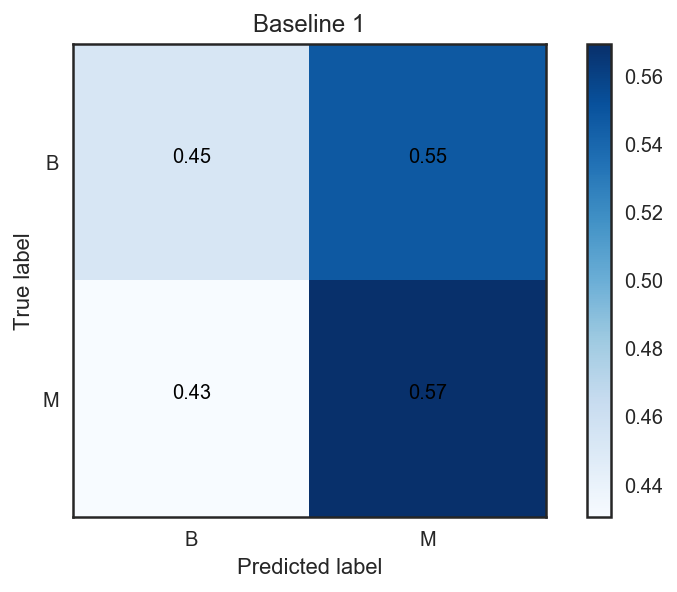

In [84]:
plot_confusion_matrix(b1_cm, classes=['B', 'M'], title='Baseline 1', normalize=True)

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


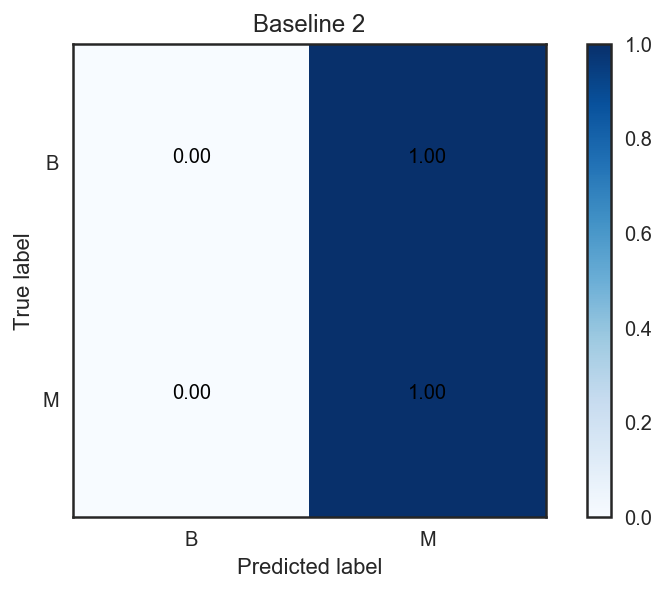

In [85]:
plot_confusion_matrix(b2_cm, classes=['B', 'M'], title='Baseline 2', normalize=True)